<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/practicals/P1.2_Word_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

# Practical Overview

 In this Practical you will learn :
- Basic concepts of word embeddings.
- How to extract word embeddings by N-Gram in a toy example.
- How to extract word embeddings by CBoW in a toy example.
- How to extract word embeddings by CBoW in `Alice in Wonderland`.
- How to perform the analogy task.




# Word Embeddings: Encoding Lexical Semantics


Word embeddings are dense vectors of real numbers, one per word in your
vocabulary. In NLP, it is almost always the case that your features are
words! But how should you represent a word in a computer? You could
store its ascii character representation, but that only tells you what
the word *is*, it doesn't say much about what it *means* (you might be
able to derive its part of speech from its affixes, or properties from
its capitalization, but not much). Even more, in what sense could you
combine these representations? We often want dense outputs from our
neural networks, where the inputs are $|V|$ dimensional, where
$V$ is our vocabulary, but often the outputs are only a few
dimensional (if we are only predicting a handful of labels, for
instance). How do we get from a massive dimensional space to a smaller
dimensional space?

How about instead of ascii representations, we use a one-hot encoding?
That is, we represent the word $w$ by
$$
\begin{align}
\overbrace{\left[ 0, 0, \dots, 1, \dots, 0, 0 \right]}^\text{|V| elements}
\end{align}
$$

where the 1 is in a location unique to $w$. Any other word will
have a 1 in some other location, and a 0 everywhere else.

There is an enormous drawback to this representation, besides just how
huge it is. It basically treats all words as independent entities with
no relation to each other. What we really want is some notion of
*similarity* between words. Why? Let's see an example.

Suppose we are building a language model. Suppose we have seen the
sentences

* The mathematician ran to the store.
* The physicist ran to the store.
* The mathematician solved the open problem.

in our training data. Now suppose we get a new sentence never before
seen in our training data:

* The physicist solved the open problem.

Our language model might do OK on this sentence, but wouldn't it be much
better if we could use the following two facts:

- We have seen  mathematician and physicist in the same role in a sentence. Somehow they
  have a semantic relation.
* We have seen mathematician in the same role  in this new unseen sentence
  as we are now seeing physicist.

and then infer that physicist is actually a good fit in the new unseen
sentence? This is what we mean by a notion of similarity: we mean
*semantic similarity*, not simply having similar orthographic
representations. It is a technique to combat the sparsity of linguistic
data, by connecting the dots between what we have seen and what we
haven't. This example of course relies on a fundamental linguistic
assumption: that words appearing in similar contexts are related to each
other semantically. This is called the [distributional
hypothesis](https://en.wikipedia.org/wiki/Distributional_semantics).


# Getting Dense Word Embeddings


How can we solve this problem? That is, how could we actually encode
semantic similarity in words? Maybe we think up some semantic
attributes. For example, we see that both mathematicians and physicists
can run, so maybe we give these words a high score for the "is able to
run" semantic attribute. Think of some other attributes, and imagine
what you might score some common words on those attributes.

If each attribute is a dimension, then we might give each word a vector,
like this:

$$
\begin{align}
q_\text{mathematician} = \left[ \overbrace{2.3}^\text{can run},
   \overbrace{9.4}^\text{likes coffee}, \overbrace{-5.5}^\text{majored in Physics}, \dots \right]
 \end{align}
$$

$$
\begin{align}
q_\text{physicist} = \left[ \overbrace{2.5}^\text{can run},
   \overbrace{9.1}^\text{likes coffee}, \overbrace{6.4}^\text{majored in Physics}, \dots \right]
\end{align}
$$

Then we can get a measure of similarity between these words by doing:

$$
\begin{align}
\text{Similarity}(\text{physicist}, \text{mathematician}) = q_\text{physicist} \cdot q_\text{mathematician}
\end{align}
$$


Although it is more common to normalize by the lengths:

\begin{align}\text{Similarity}(\text{physicist}, \text{mathematician}) = \frac{q_\text{physicist} \cdot q_\text{mathematician}}
   {\| q_\text{physicist} \| \| q_\text{mathematician} \|} = \cos (\phi)\end{align}

Where $\phi$ is the angle between the two vectors. That way,
extremely similar words (words whose embeddings point in the same
direction) will have similarity 1. Extremely dissimilar words should
have similarity -1.



You can think of the sparse one-hot vectors from the beginning of this
section as a special case of these new vectors we have defined, where
each word basically has similarity 0, and we gave each word some unique
semantic attribute. These new vectors are *dense*, which is to say their
entries are (typically) non-zero.

But these new vectors are a big pain: you could think of thousands of
different semantic attributes that might be relevant to determining
similarity, and how on earth would you set the values of the different
attributes? Central to the idea of deep learning is that the neural
network learns representations of the features, rather than requiring
the programmer to design them herself. So why not just let the word
embeddings be parameters in our model, and then be updated during
training? This is exactly what we will do. We will have some *latent
semantic attributes* that the network can, in principle, learn. Note
that the word embeddings will probably not be interpretable. That is,
although with our hand-crafted vectors above we can see that
mathematicians and physicists are similar in that they both like coffee,
if we allow a neural network to learn the embeddings and see that both
mathematicians and physicists have a large value in the second
dimension, it is not clear what that means. They are similar in some
latent semantic dimension, but this probably has no interpretation to
us.


In summary, **word embeddings are a representation of the *semantics* of
a word, efficiently encoding semantic information that might be relevant
to the task at hand**. You can embed other things too: part of speech
tags, parse trees, anything! The idea of feature embeddings is central
to the field.


# Word Embeddings in Pytorch


Before we get to a worked example and an exercise, a few quick notes
about how to use embeddings in Pytorch and in deep learning programming
in general. Similar to how we defined a unique index for each word when
making one-hot vectors, we also need to define an index for each word
when using embeddings. These will be keys into a lookup table. That is,
embeddings are stored as a $|V| \times D$ matrix, where $D$
is the dimensionality of the embeddings, such that the word assigned
index $i$ has its embedding stored in the $i$'th row of the
matrix. In all of code, the mapping from words to indices is a
dictionary named word\_to\_ix.

The module that allows you to use embeddings is torch.nn.Embedding,
which takes two arguments: the vocabulary size, and the dimensionality
of the embeddings.

To index into this table, you must use torch.LongTensor (since the
indices are integers, not floats).



In [ ]:
# Author: Robert Guthrie

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
torch.manual_seed(1)

In [ ]:
word_to_ix = {"hello": 0, "world": 1}
embeds = nn.Embedding(2, 5)  # 2 words in vocab, 5 dimensional embeddings
lookup_tensor = torch.tensor([word_to_ix["hello"]], dtype=torch.long)
hello_embed = embeds(lookup_tensor)
print(hello_embed)

tensor([[ 0.6614,  0.2669,  0.0617,  0.6213, -0.4519]],
       grad_fn=<EmbeddingBackward0>)


# Example  N-Gram Language Modeling in a Toy example


Recall that in an n-gram language model, given a sequence of words
$w$, we want to compute

\begin{align}P(w_i | w_{i-1}, w_{i-2}, \dots, w_{i-n+1} )\end{align}

Where $w_i$ is the ith word of the sequence.

In this example, we will compute the loss function on some training
examples and update the parameters with backpropagation.




##  Data Preprocessing

Before we can use the data in our model, we should build a list of tuples.  Each tuple is `([ word_i-2, word_i-1 ], target word)`, we also build dictionaries to map from words to indices, i.e. word_to_ix, and map from indices to words, i.e. ix_to_word,

In [ ]:
CONTEXT_SIZE = 2

# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
# print the first 3, just so you can see what they look like
print(trigrams[:3])


vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {ix:word for ix, word in enumerate(vocab)}


[(['When', 'forty'], 'winters'), (['forty', 'winters'], 'shall'), (['winters', 'shall'], 'besiege')]


## Create N-Gram model
We create N-Gram language model, and set the word embedding size to be 100 (or other by your preferance)

In [ ]:
EMBEDDING_DIM = 100

class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        # see this article at super deep dive for explanation of this super usage: https://realpython.com/python-super/
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):

        # just gets the embeddings based on inputs which is an index tensor with indexes of the context words
        # view is here done on the embeddings tensor that is given back and view is same as reshape but then not a copy but a view
        # gives back a reshaped view of 1 row and automatically calculated amount of columns => so flattened embeddings to one input layer
        # just like how I thought it was done in the assigned paper
        embeds = self.embeddings(inputs).view((1, -1))
        # here the embeddings of context are fed as input
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs



loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(100):
    total_loss = 0
    for context, target in trigrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    average_loss= total_loss/len(trigrams)
    print('Epoch:', epoch, '\tLoss:', average_loss)  # The loss decreased every iteration over the training data!

Epoch: 0 	Loss: 4.587412726562635
Epoch: 1 	Loss: 4.5376294460971796
Epoch: 2 	Loss: 4.488432059245827
Epoch: 3 	Loss: 4.439731551482614
Epoch: 4 	Loss: 4.391400005965107
Epoch: 5 	Loss: 4.343557305040613
Epoch: 6 	Loss: 4.295908695828598
Epoch: 7 	Loss: 4.2485179964420015
Epoch: 8 	Loss: 4.201386033961203
Epoch: 9 	Loss: 4.154456704063753
Epoch: 10 	Loss: 4.107420674467509
Epoch: 11 	Loss: 4.060434043934915
Epoch: 12 	Loss: 4.013202350751489
Epoch: 13 	Loss: 3.965808452758114
Epoch: 14 	Loss: 3.9183447972863124
Epoch: 15 	Loss: 3.8706730213840452
Epoch: 16 	Loss: 3.822744555177942
Epoch: 17 	Loss: 3.7745363311429996
Epoch: 18 	Loss: 3.7259710636814085
Epoch: 19 	Loss: 3.677006086417004
Epoch: 20 	Loss: 3.627793090533366
Epoch: 21 	Loss: 3.5780951681390274
Epoch: 22 	Loss: 3.5279812601815284
Epoch: 23 	Loss: 3.477516973968101
Epoch: 24 	Loss: 3.426555926820873
Epoch: 25 	Loss: 3.374985382620212
Epoch: 26 	Loss: 3.322998952021641
Epoch: 27 	Loss: 3.270548687571973
Epoch: 28 	Loss: 3.217

##  Check the results

We can print the word embedding value by creating pandas table

In [ ]:
import pandas as pd
embeddings = model.embeddings(torch.Tensor([list(range(0,len(vocab)))]).long())
embeddings = embeddings.view(-1,100)
pd.DataFrame(embeddings.tolist(), index=list(ix_to_word.values())[0:]).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
deserv'd,0.865660,0.244538,-0.662447,0.808555,0.439727,1.173195,1.770056,-0.096425,0.060710,-0.619431,...,-1.481377,-1.134949,-0.104028,0.341967,-1.069792,-0.872024,0.205613,0.302507,0.534544,-0.429046
Where,0.157127,1.257070,1.327929,-0.494574,-1.983686,1.800952,0.099672,0.340075,-0.645444,-0.289382,...,-1.103502,-0.702326,0.233184,1.916728,1.838384,1.325574,-0.070411,0.346034,-0.653575,1.559438
gazed,0.219844,-0.573221,1.461602,1.773535,-2.019674,0.423500,0.574479,-1.798754,1.249897,1.277142,...,0.249154,-0.390823,-0.200063,-0.839226,-1.556213,-0.058821,1.198790,-2.285320,-1.016021,-0.890554
where,0.144156,0.207144,1.053367,0.131243,1.404480,0.489909,-0.706377,-0.826422,0.099670,0.195354,...,0.349093,-0.551437,-0.964892,0.275876,-0.679017,-0.543213,1.152540,-0.405237,0.973702,1.546424
If,-0.374242,-2.411841,-1.280049,-0.062242,-1.230385,-1.064384,-0.389951,0.378186,-0.208622,0.694781,...,0.295048,-0.565559,0.726771,-0.548047,-0.802087,0.019027,-0.152020,0.524376,-0.213958,-1.256801


We can also plot the TSNE to visualize the similarity

In [ ]:
labels=[]
for i in range(len(ix_to_word)):
    labels.append(ix_to_word[i])


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


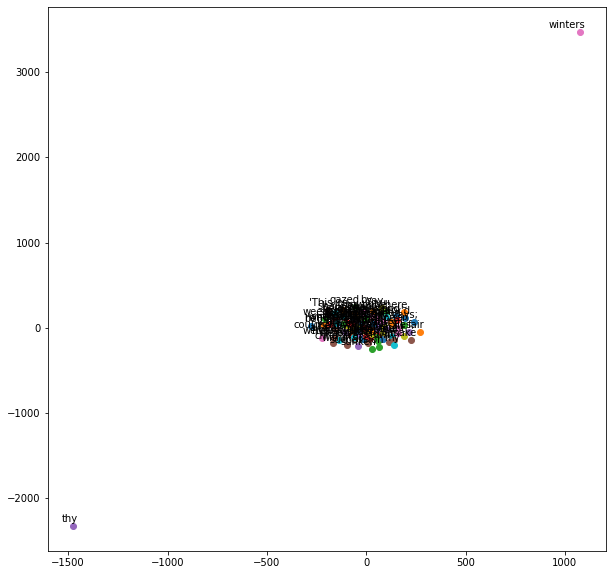

In [ ]:
from matplotlib import pylab
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
two_d_embeddings = tsne.fit_transform(embeddings.detach().numpy())

def plot(embeddings, labels):
      assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
      pylab.figure(figsize=(10,10))  # in inches
      for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
      pylab.show()


plot(two_d_embeddings, labels)

In [ ]:
context = ['When','forty']

a = model(torch.tensor([word_to_ix[w] for w in context]))

#Print result
print(f'Raw text: {" ".join(test_sentence)}\n')
print(f'Context: {context}\n')
print(f'Prediction: {ix_to_word[torch.argmax(a[0]).item()]}')

Raw text: When forty winters shall besiege thy brow, And dig deep trenches in thy beauty's field, Thy youth's proud livery so gazed on now, Will be a totter'd weed of small worth held: Then being asked, where all thy beauty lies, Where all the treasure of thy lusty days; To say, within thine own deep sunken eyes, Were an all-eating shame, and thriftless praise. How much more praise deserv'd thy beauty's use, If thou couldst answer 'This fair child of mine Shall sum my count, and make my old excuse,' Proving his beauty by succession thine! This were to be new made when thou art old, And see thy blood warm when thou feel'st it cold.

Context: ['When', 'forty']

Prediction: winters


# Practical. 1: Computing Word Embeddings: Continuous Bag-of-Words in a Toy example



The Continuous Bag-of-Words model (CBOW) is frequently used in NLP deep
learning. It is a model that tries to predict words given the context of
a few words before and a few words after the target word. This is
distinct from language modeling, since CBOW is not sequential and does
not have to be probabilistic. Typcially, CBOW is used to quickly train
word embeddings, and these embeddings are used to initialize the
embeddings of some more complicated model. Usually, this is referred to
as *pretraining embeddings*. It almost always helps performance a couple
of percent.

The CBOW model is as follows. Given a target word $w_i$ and an
$N$ context window on each side, $w_{i-1}, \dots, w_{i-N}$
and $w_{i+1}, \dots, w_{i+N}$, referring to all context words
collectively as $C$, CBOW tries to minimize,

$$
\begin{align}
-\log p(w_i | C) = -\log \text{Softmax}(A(\sum_{w \in C} q_w) + b)
\end{align}
$$

where $q_w$ is the embedding for word $w$.

Implement this model in Pytorch by filling in the class below. Some
tips:

* Think about which parameters you need to define.
* Make sure you know what shape each operation expects. Use .view() if you need to
  reshape.




##  Data Preprocessing

The CBOW model architecture tries to predict the current target word (the center word) based on the source context words (surrounding words). Considering a simple sentence, `the quick brown fox jumps over the lazy dog`, this can be pairs of (context_window, target_word) where if we consider a context size 2 (2 words to the left, 2 to the right),  we have examples like `([the, quick, fox, jumps], brown)` and so on. Thus the model tries to predict the target_word based on the context_window words.


Therefore should build a list of tuples.  Each tuple is `([ word_i-2, word_i-1,word_i+1, word_i+2 ], target word)`, we also build dictionaries to map from words to indices, i.e. word_to_ix, and map from indices to words, i.e. ix_to_word,

In [ ]:
import torch
import torch.nn as nn


CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
EMBEDDING_DIM = 100

raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()


# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)

word_to_ix = {word:ix for ix, word in enumerate(vocab)}
ix_to_word = {ix:word for ix, word in enumerate(vocab)}

data = []
for i in range(2, len(raw_text) - 2):
    context = [raw_text[i - 2], raw_text[i - 1],
               raw_text[i + 1], raw_text[i + 2]]
    target = raw_text[i]
    data.append((context, target))

# print(context) 
# print(trigrams)
print(data[:5])

[(['We', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'a'], 'idea')]



## Create CBoW Model
Following is an image to illustrate the model architecture. We set the word embedding size to be 100 (or other by your preference).

![avatar](https://miro.medium.com/max/328/1*bkrBASpteKfCaxZDEEeN6g.png)

In [ ]:
EMBEDDING_DIM = 100

class CBOW(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, vocab_size)


    def forward(self, inputs):
        # just gets the embeddings based on inputs which is an index tensor with indexes of the context words
        # view is here done on the embeddings tensor that is given back and view is same as reshape but then not a copy but a view
        # gives back a reshaped view of 1 row and automatically calculated amount of columns => so flattened embeddings to one input layer
        # just like how I thought it was done in the assigned paper
        embeds = self.embeddings(inputs).mean(dim=0).view((1, -1))
        # here the embeddings of context are fed as input
        out = self.linear1(embeds)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

# create your model and train.  here are some functions to help you make
# the data ready for use by your module

def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)


loss_function = nn.NLLLoss()
model = CBOW(vocab_size, EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

#TRAINING
for epoch in range(50):
    total_loss = 0
    for context, target in data:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = make_context_vector(context, word_to_ix)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    average_loss= total_loss/len(data)
    print('Epoch:', epoch, '\tLoss:', average_loss)  # The loss decreased every iteration over the training data!

Epoch: 0 	Loss: 3.946759955636386
Epoch: 1 	Loss: 3.921360731124878
Epoch: 2 	Loss: 3.8960641622543335
Epoch: 3 	Loss: 3.8708710506044586
Epoch: 4 	Loss: 3.845781979889705
Epoch: 5 	Loss: 3.8207976818084717
Epoch: 6 	Loss: 3.7959189908257844
Epoch: 7 	Loss: 3.7711465112094222
Epoch: 8 	Loss: 3.746481019875099
Epoch: 9 	Loss: 3.721923219746557
Epoch: 10 	Loss: 3.6974739288461618
Epoch: 11 	Loss: 3.673133706224376
Epoch: 12 	Loss: 3.648903411010216
Epoch: 13 	Loss: 3.6247837173527686
Epoch: 14 	Loss: 3.6007753446184356
Epoch: 15 	Loss: 3.576878987509629
Epoch: 16 	Loss: 3.5530953407287598
Epoch: 17 	Loss: 3.529425123642231
Epoch: 18 	Loss: 3.5058690556164445
Epoch: 19 	Loss: 3.4824277655831697
Epoch: 20 	Loss: 3.4591018948061714
Epoch: 21 	Loss: 3.435892174983847
Epoch: 22 	Loss: 3.412799226826635
Epoch: 23 	Loss: 3.389823576499676
Epoch: 24 	Loss: 3.3669659351480417
Epoch: 25 	Loss: 3.3442268536008637
Epoch: 26 	Loss: 3.3216069114619287
Epoch: 27 	Loss: 3.299106610232386
Epoch: 28 	Loss

##  Check the results

Then we check the results by making predictions of target work by context

In [ ]:
context = ['People','create','to', 'direct']
context_vector = make_context_vector(context, word_to_ix)
a = model(context_vector)

#Print result
print(f'Raw text: {" ".join(raw_text)}\n')
print(f'Context: {context}\n')
print(f'Prediction: {ix_to_word[torch.argmax(a[0]).item()]}')

Raw text: We are about to study the idea of a computational process. Computational processes are abstract beings that inhabit computers. As they evolve, processes manipulate other abstract things called data. The evolution of a process is directed by a pattern of rules called a program. People create programs to direct processes. In effect, we conjure the spirits of the computer with our spells.

Context: ['People', 'create', 'to', 'direct']

Prediction: programs


# Practical. 2: Computing Word Embeddings in  `Alice in Wonderland` using CBoW

Now let's try to build word embedding in a  ‘Alice in Wonderland’ instead of a toy example.  Download the word-label mapping dictionaries and corpus by this [link](https://drive.google.com/drive/folders/1mYM29PbWQ4rS0bgKndFJjZlkbcwMaEpO?usp=sharing), and upload them into your own google drive. After that, mount them to the drive folder so we can use them in colab by:

##  Data Preprocessing

In [ ]:
from google.colab import drive
!mkdir drive
drive.mount('drive')

Mounted at drive


Then we list all the data in your drive to see if we mount successfully.

In [ ]:
!ls "drive/My Drive/"

 2AMS10_groep4
'Avans University Mail - Tentamen bestand verloren door vastlopen programma.pdf'
'Colab Notebooks'
'Crypto Portfolio'
'Kopie van Workshop 8.gsheet'
'Kopie van Workshop 8 - new guidelines.gsheet'
'Naamloos document.gdoc'
'Security Shoulder surfing.gdoc'
 Tue
 TwanMarta.jpg
 ubuntu_32_v2.zip
'Untitled Diagram.drawio'


In [ ]:
# modify the path according to your own file location
import os
data_path=os.path.join("drive/MyDrive/Tue/deep_learning/tue-deeplearning/practicals/Word_embedding_data/")


Then we load the data

In [ ]:
import json
with open(os.path.join(data_path,"alice.json"),'r') as f:
    alice = json.load(f)
with open(os.path.join(data_path,"ix_to_word.json"),'r') as f:
    ix_to_word = json.load(f)
with open(os.path.join(data_path,"word_to_ix.json"),'r') as f:
    word_to_ix = json.load(f)

Then we create the context and target pair with the help of keras function, we set the window_size 2 (2 words to the left, 2 to the right)

In [ ]:
window_size=2
vocab_size=len(word_to_ix)

from keras.preprocessing import text
from keras.preprocessing import sequence

corpus = [[word_to_ix[w] for w in text.text_to_word_sequence(doc)] for doc in alice]

def generate_context_word_pairs(corpus, window_size, vocab_size):
    X = []
    Y = []
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):           
            start = index - window_size
            end = index + window_size + 1
            # skip index words in range start to end (so middle word is skipped)
            context = [words[i] for i in range(start, end)if 0 <= i < sentence_length and i != index]
            # and fill in placement 0 at the start of the context list where i = -1 or -2 (index out of range) as padding
            # to always get same length sequences
            x = sequence.pad_sequences([context], maxlen=context_length)[0]
            X.append(x)
            Y.append([word])

    X=torch.tensor(X, dtype=torch.long)
    Y=torch.tensor(Y, dtype=torch.long)
    return X,Y

X,Y = generate_context_word_pairs(corpus, window_size=window_size, vocab_size=vocab_size)
print(X, Y)

tensor([[   0,    0,  337,  669],
        [   0,    2,  669, 1273],
        [   2,  337, 1273, 1274],
        ...,
        [ 218,  194, 1256,  637],
        [   0,  194, 2378,  637],
        [   0,    0, 2378, 1256]]) tensor([[   2],
        [ 337],
        [ 669],
        ...,
        [2378],
        [1256],
        [ 637]])



##  Create CBoW Model
Now we create CBoW model, we could set the word embedding size to be 100 (or other by your preference).

In [ ]:
class CBOW(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs):
        # we are working with batches so should do the mean of second dimension as the 
        # first dimension is the samples in batch
        embeds = self.embeddings(inputs).mean(dim=1)
        out = self.linear1(embeds)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs
    
    
EMBEDDING_DIM=100
model = CBOW(vocab_size,EMBEDDING_DIM)

Remember to move your model to GPU because now we are training with a lot of corpus.

In [ ]:
# https://towardsdatascience.com/pytorch-switching-to-the-gpu-a7c0b21e8a99
# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CBOW(vocab_size, EMBEDDING_DIM)
model.to(device)
next(model.parameters()).is_cuda

True

Then we train the model and print the loss. Loss should decrease every iteration over the training data. Play with the epochs numbers here, recommend 200 or above.

In [ ]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    
    output=model(xb)
    # remove axis with dimension of length one for nlllos
    yb = yb.squeeze()
    loss = loss_func(output, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    _, preds = torch.max(output, 1)
    corrects = torch.sum(preds == yb.data)

    # print(loss.item())
    
    return loss.item(), corrects, len(xb)

In [ ]:
from tqdm import tqdm
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

#TRAINING
epochs = 200
bs=10
train_ds = TensorDataset(X, Y)
train_dl = DataLoader(train_ds, batch_size=bs)
optimizer = optim.SGD(model.parameters(), lr=0.001)


for epoch in tqdm(range(epochs)):
    
    
    # training process
    model.train()

    running_loss = 0.0
    running_corrects = 0
    sample_num=0
    for xb, yb in train_dl:

        xb = xb.to(device)
        yb = yb.to(device)

        # forward
        # backward and optimize only if in training phase
        losses, corrects, nums = loss_batch(model, loss_function, xb, yb,optimizer)
        
        # statistics
        # we do the loss of the batch times the size of the batch as we want total
        # loss and NLLLOS gives us a mean loss over the batch (by default, can change by setting reduction). So multiplying by size of batch gives us back the total loss
        running_loss += losses * xb.size(0)
        running_corrects += corrects
        sample_num+=nums
        
    train_loss = running_loss / sample_num
    train_acc = running_corrects.double() / sample_num
    print(
          f'EPOCH: {epoch+1:0>{len(str(epochs))}}/{epochs}',
          end=' '
      )
    print(f'LOSS: {train_loss:.4f}',f'ACC: {train_acc:.4f} ',end='\n')
# === ADD CODE HERE ===

  0%|          | 1/200 [00:02<08:31,  2.57s/it]

EPOCH: 001/200 LOSS: 6.3554 ACC: 0.0749 


  1%|          | 2/200 [00:05<08:31,  2.59s/it]

EPOCH: 002/200 LOSS: 6.3523 ACC: 0.0749 


  2%|▏         | 3/200 [00:07<08:25,  2.56s/it]

EPOCH: 003/200 LOSS: 6.3492 ACC: 0.0749 


  2%|▏         | 4/200 [00:09<07:14,  2.22s/it]

EPOCH: 004/200 LOSS: 6.3462 ACC: 0.0750 


  2%|▎         | 5/200 [00:11<06:33,  2.02s/it]

EPOCH: 005/200 LOSS: 6.3431 ACC: 0.0751 


  3%|▎         | 6/200 [00:12<06:11,  1.92s/it]

EPOCH: 006/200 LOSS: 6.3400 ACC: 0.0751 


  4%|▎         | 7/200 [00:14<05:55,  1.84s/it]

EPOCH: 007/200 LOSS: 6.3370 ACC: 0.0752 


  4%|▍         | 8/200 [00:16<05:45,  1.80s/it]

EPOCH: 008/200 LOSS: 6.3340 ACC: 0.0755 


  4%|▍         | 9/200 [00:17<05:37,  1.77s/it]

EPOCH: 009/200 LOSS: 6.3309 ACC: 0.0759 


  5%|▌         | 10/200 [00:19<05:31,  1.75s/it]

EPOCH: 010/200 LOSS: 6.3279 ACC: 0.0761 


  6%|▌         | 11/200 [00:21<05:26,  1.73s/it]

EPOCH: 011/200 LOSS: 6.3249 ACC: 0.0763 


  6%|▌         | 12/200 [00:22<05:22,  1.72s/it]

EPOCH: 012/200 LOSS: 6.3219 ACC: 0.0762 


  6%|▋         | 13/200 [00:24<05:19,  1.71s/it]

EPOCH: 013/200 LOSS: 6.3189 ACC: 0.0763 


  7%|▋         | 14/200 [00:26<05:18,  1.71s/it]

EPOCH: 014/200 LOSS: 6.3159 ACC: 0.0762 


  8%|▊         | 15/200 [00:28<05:15,  1.71s/it]

EPOCH: 015/200 LOSS: 6.3129 ACC: 0.0764 


  8%|▊         | 16/200 [00:29<05:13,  1.70s/it]

EPOCH: 016/200 LOSS: 6.3099 ACC: 0.0763 


  8%|▊         | 17/200 [00:31<05:12,  1.71s/it]

EPOCH: 017/200 LOSS: 6.3069 ACC: 0.0764 


  9%|▉         | 18/200 [00:33<05:09,  1.70s/it]

EPOCH: 018/200 LOSS: 6.3039 ACC: 0.0764 


 10%|▉         | 19/200 [00:34<05:08,  1.71s/it]

EPOCH: 019/200 LOSS: 6.3010 ACC: 0.0763 


 10%|█         | 20/200 [00:36<05:08,  1.71s/it]

EPOCH: 020/200 LOSS: 6.2980 ACC: 0.0766 


 10%|█         | 21/200 [00:38<05:03,  1.69s/it]

EPOCH: 021/200 LOSS: 6.2951 ACC: 0.0766 


 11%|█         | 22/200 [00:39<05:01,  1.69s/it]

EPOCH: 022/200 LOSS: 6.2921 ACC: 0.0767 


 12%|█▏        | 23/200 [00:41<05:00,  1.70s/it]

EPOCH: 023/200 LOSS: 6.2892 ACC: 0.0768 


 12%|█▏        | 24/200 [00:43<04:58,  1.70s/it]

EPOCH: 024/200 LOSS: 6.2862 ACC: 0.0768 


 12%|█▎        | 25/200 [00:45<04:57,  1.70s/it]

EPOCH: 025/200 LOSS: 6.2833 ACC: 0.0768 


 13%|█▎        | 26/200 [00:46<04:56,  1.70s/it]

EPOCH: 026/200 LOSS: 6.2804 ACC: 0.0769 


 14%|█▎        | 27/200 [00:48<04:53,  1.70s/it]

EPOCH: 027/200 LOSS: 6.2775 ACC: 0.0772 


 14%|█▍        | 28/200 [00:50<04:51,  1.69s/it]

EPOCH: 028/200 LOSS: 6.2746 ACC: 0.0772 


 14%|█▍        | 29/200 [00:51<04:50,  1.70s/it]

EPOCH: 029/200 LOSS: 6.2717 ACC: 0.0776 


 15%|█▌        | 30/200 [00:53<04:48,  1.70s/it]

EPOCH: 030/200 LOSS: 6.2688 ACC: 0.0776 


 16%|█▌        | 31/200 [00:55<04:48,  1.71s/it]

EPOCH: 031/200 LOSS: 6.2659 ACC: 0.0779 


 16%|█▌        | 32/200 [00:56<04:47,  1.71s/it]

EPOCH: 032/200 LOSS: 6.2630 ACC: 0.0780 


 16%|█▋        | 33/200 [00:58<04:46,  1.71s/it]

EPOCH: 033/200 LOSS: 6.2601 ACC: 0.0782 


 17%|█▋        | 34/200 [01:00<04:46,  1.72s/it]

EPOCH: 034/200 LOSS: 6.2572 ACC: 0.0782 


 18%|█▊        | 35/200 [01:02<04:43,  1.72s/it]

EPOCH: 035/200 LOSS: 6.2543 ACC: 0.0785 


 18%|█▊        | 36/200 [01:03<04:43,  1.73s/it]

EPOCH: 036/200 LOSS: 6.2515 ACC: 0.0786 


 18%|█▊        | 37/200 [01:05<04:44,  1.74s/it]

EPOCH: 037/200 LOSS: 6.2486 ACC: 0.0786 


 19%|█▉        | 38/200 [01:07<04:41,  1.74s/it]

EPOCH: 038/200 LOSS: 6.2458 ACC: 0.0786 


 20%|█▉        | 39/200 [01:09<04:39,  1.73s/it]

EPOCH: 039/200 LOSS: 6.2429 ACC: 0.0787 


 20%|██        | 40/200 [01:10<04:35,  1.72s/it]

EPOCH: 040/200 LOSS: 6.2401 ACC: 0.0788 


 20%|██        | 41/200 [01:12<04:33,  1.72s/it]

EPOCH: 041/200 LOSS: 6.2373 ACC: 0.0790 


 21%|██        | 42/200 [01:14<04:31,  1.72s/it]

EPOCH: 042/200 LOSS: 6.2344 ACC: 0.0790 


 22%|██▏       | 43/200 [01:16<04:31,  1.73s/it]

EPOCH: 043/200 LOSS: 6.2316 ACC: 0.0791 


 22%|██▏       | 44/200 [01:17<04:27,  1.72s/it]

EPOCH: 044/200 LOSS: 6.2288 ACC: 0.0790 


 22%|██▎       | 45/200 [01:19<04:24,  1.71s/it]

EPOCH: 045/200 LOSS: 6.2260 ACC: 0.0791 


 23%|██▎       | 46/200 [01:21<04:23,  1.71s/it]

EPOCH: 046/200 LOSS: 6.2232 ACC: 0.0791 


 24%|██▎       | 47/200 [01:22<04:23,  1.72s/it]

EPOCH: 047/200 LOSS: 6.2204 ACC: 0.0792 


 24%|██▍       | 48/200 [01:24<04:20,  1.71s/it]

EPOCH: 048/200 LOSS: 6.2176 ACC: 0.0795 


 24%|██▍       | 49/200 [01:26<04:21,  1.73s/it]

EPOCH: 049/200 LOSS: 6.2148 ACC: 0.0795 


 25%|██▌       | 50/200 [01:28<04:18,  1.72s/it]

EPOCH: 050/200 LOSS: 6.2120 ACC: 0.0796 


 26%|██▌       | 51/200 [01:29<04:14,  1.71s/it]

EPOCH: 051/200 LOSS: 6.2092 ACC: 0.0795 


 26%|██▌       | 52/200 [01:31<04:11,  1.70s/it]

EPOCH: 052/200 LOSS: 6.2064 ACC: 0.0795 


 26%|██▋       | 53/200 [01:33<04:08,  1.69s/it]

EPOCH: 053/200 LOSS: 6.2036 ACC: 0.0797 


 27%|██▋       | 54/200 [01:34<04:06,  1.69s/it]

EPOCH: 054/200 LOSS: 6.2009 ACC: 0.0797 


 28%|██▊       | 55/200 [01:36<04:04,  1.69s/it]

EPOCH: 055/200 LOSS: 6.1981 ACC: 0.0797 


 28%|██▊       | 56/200 [01:38<04:03,  1.69s/it]

EPOCH: 056/200 LOSS: 6.1954 ACC: 0.0798 


 28%|██▊       | 57/200 [01:39<04:01,  1.69s/it]

EPOCH: 057/200 LOSS: 6.1926 ACC: 0.0800 


 29%|██▉       | 58/200 [01:41<04:00,  1.69s/it]

EPOCH: 058/200 LOSS: 6.1899 ACC: 0.0800 


 30%|██▉       | 59/200 [01:43<03:58,  1.69s/it]

EPOCH: 059/200 LOSS: 6.1871 ACC: 0.0803 


 30%|███       | 60/200 [01:44<03:57,  1.69s/it]

EPOCH: 060/200 LOSS: 6.1844 ACC: 0.0807 


 30%|███       | 61/200 [01:46<03:56,  1.70s/it]

EPOCH: 061/200 LOSS: 6.1817 ACC: 0.0808 


 31%|███       | 62/200 [01:48<03:53,  1.69s/it]

EPOCH: 062/200 LOSS: 6.1789 ACC: 0.0810 


 32%|███▏      | 63/200 [01:49<03:51,  1.69s/it]

EPOCH: 063/200 LOSS: 6.1762 ACC: 0.0811 


 32%|███▏      | 64/200 [01:51<03:57,  1.74s/it]

EPOCH: 064/200 LOSS: 6.1735 ACC: 0.0811 


 32%|███▎      | 65/200 [01:53<04:08,  1.84s/it]

EPOCH: 065/200 LOSS: 6.1708 ACC: 0.0813 


 33%|███▎      | 66/200 [01:55<04:01,  1.80s/it]

EPOCH: 066/200 LOSS: 6.1681 ACC: 0.0814 


 34%|███▎      | 67/200 [01:57<03:55,  1.77s/it]

EPOCH: 067/200 LOSS: 6.1654 ACC: 0.0814 


 34%|███▍      | 68/200 [01:59<03:50,  1.75s/it]

EPOCH: 068/200 LOSS: 6.1627 ACC: 0.0816 


 34%|███▍      | 69/200 [02:00<03:47,  1.73s/it]

EPOCH: 069/200 LOSS: 6.1600 ACC: 0.0816 


 35%|███▌      | 70/200 [02:02<03:43,  1.72s/it]

EPOCH: 070/200 LOSS: 6.1573 ACC: 0.0817 


 36%|███▌      | 71/200 [02:04<03:39,  1.70s/it]

EPOCH: 071/200 LOSS: 6.1546 ACC: 0.0820 


 36%|███▌      | 72/200 [02:05<03:39,  1.71s/it]

EPOCH: 072/200 LOSS: 6.1520 ACC: 0.0819 


 36%|███▋      | 73/200 [02:07<03:37,  1.71s/it]

EPOCH: 073/200 LOSS: 6.1493 ACC: 0.0822 


 37%|███▋      | 74/200 [02:09<03:35,  1.71s/it]

EPOCH: 074/200 LOSS: 6.1466 ACC: 0.0822 


 38%|███▊      | 75/200 [02:10<03:34,  1.71s/it]

EPOCH: 075/200 LOSS: 6.1440 ACC: 0.0822 


 38%|███▊      | 76/200 [02:12<03:32,  1.71s/it]

EPOCH: 076/200 LOSS: 6.1413 ACC: 0.0824 


 38%|███▊      | 77/200 [02:14<03:30,  1.71s/it]

EPOCH: 077/200 LOSS: 6.1386 ACC: 0.0825 


 39%|███▉      | 78/200 [02:16<03:29,  1.72s/it]

EPOCH: 078/200 LOSS: 6.1360 ACC: 0.0827 


 40%|███▉      | 79/200 [02:17<03:26,  1.71s/it]

EPOCH: 079/200 LOSS: 6.1333 ACC: 0.0827 


 40%|████      | 80/200 [02:19<03:25,  1.71s/it]

EPOCH: 080/200 LOSS: 6.1307 ACC: 0.0830 


 40%|████      | 81/200 [02:21<03:23,  1.71s/it]

EPOCH: 081/200 LOSS: 6.1281 ACC: 0.0830 


 41%|████      | 82/200 [02:22<03:21,  1.71s/it]

EPOCH: 082/200 LOSS: 6.1254 ACC: 0.0833 


 42%|████▏     | 83/200 [02:24<03:19,  1.70s/it]

EPOCH: 083/200 LOSS: 6.1228 ACC: 0.0833 


 42%|████▏     | 84/200 [02:26<03:18,  1.71s/it]

EPOCH: 084/200 LOSS: 6.1202 ACC: 0.0834 


 42%|████▎     | 85/200 [02:28<03:17,  1.71s/it]

EPOCH: 085/200 LOSS: 6.1176 ACC: 0.0834 


 43%|████▎     | 86/200 [02:29<03:14,  1.70s/it]

EPOCH: 086/200 LOSS: 6.1150 ACC: 0.0834 


 44%|████▎     | 87/200 [02:31<03:12,  1.70s/it]

EPOCH: 087/200 LOSS: 6.1124 ACC: 0.0835 


 44%|████▍     | 88/200 [02:33<03:10,  1.70s/it]

EPOCH: 088/200 LOSS: 6.1098 ACC: 0.0837 


 44%|████▍     | 89/200 [02:34<03:07,  1.69s/it]

EPOCH: 089/200 LOSS: 6.1072 ACC: 0.0840 


 45%|████▌     | 90/200 [02:36<03:06,  1.69s/it]

EPOCH: 090/200 LOSS: 6.1046 ACC: 0.0843 


 46%|████▌     | 91/200 [02:38<03:04,  1.69s/it]

EPOCH: 091/200 LOSS: 6.1020 ACC: 0.0844 


 46%|████▌     | 92/200 [02:39<03:02,  1.69s/it]

EPOCH: 092/200 LOSS: 6.0994 ACC: 0.0846 


 46%|████▋     | 93/200 [02:41<03:00,  1.69s/it]

EPOCH: 093/200 LOSS: 6.0968 ACC: 0.0846 


 47%|████▋     | 94/200 [02:43<03:13,  1.82s/it]

EPOCH: 094/200 LOSS: 6.0942 ACC: 0.0845 


 48%|████▊     | 95/200 [02:45<03:07,  1.79s/it]

EPOCH: 095/200 LOSS: 6.0917 ACC: 0.0845 


 48%|████▊     | 96/200 [02:47<03:02,  1.75s/it]

EPOCH: 096/200 LOSS: 6.0891 ACC: 0.0846 


 48%|████▊     | 97/200 [02:48<02:59,  1.74s/it]

EPOCH: 097/200 LOSS: 6.0865 ACC: 0.0847 


 49%|████▉     | 98/200 [02:50<02:56,  1.73s/it]

EPOCH: 098/200 LOSS: 6.0840 ACC: 0.0847 


 50%|████▉     | 99/200 [02:52<02:55,  1.73s/it]

EPOCH: 099/200 LOSS: 6.0814 ACC: 0.0847 


 50%|█████     | 100/200 [02:53<02:51,  1.72s/it]

EPOCH: 100/200 LOSS: 6.0788 ACC: 0.0848 


 50%|█████     | 101/200 [02:55<02:49,  1.71s/it]

EPOCH: 101/200 LOSS: 6.0763 ACC: 0.0850 


 51%|█████     | 102/200 [02:57<02:46,  1.70s/it]

EPOCH: 102/200 LOSS: 6.0738 ACC: 0.0852 


 52%|█████▏    | 103/200 [02:59<02:45,  1.71s/it]

EPOCH: 103/200 LOSS: 6.0712 ACC: 0.0853 


 52%|█████▏    | 104/200 [03:00<02:43,  1.71s/it]

EPOCH: 104/200 LOSS: 6.0687 ACC: 0.0854 


 52%|█████▎    | 105/200 [03:02<02:42,  1.71s/it]

EPOCH: 105/200 LOSS: 6.0661 ACC: 0.0855 


 53%|█████▎    | 106/200 [03:04<02:40,  1.71s/it]

EPOCH: 106/200 LOSS: 6.0636 ACC: 0.0858 


 54%|█████▎    | 107/200 [03:05<02:38,  1.70s/it]

EPOCH: 107/200 LOSS: 6.0611 ACC: 0.0858 


 54%|█████▍    | 108/200 [03:07<02:35,  1.69s/it]

EPOCH: 108/200 LOSS: 6.0586 ACC: 0.0858 


 55%|█████▍    | 109/200 [03:09<02:34,  1.70s/it]

EPOCH: 109/200 LOSS: 6.0561 ACC: 0.0858 


 55%|█████▌    | 110/200 [03:10<02:33,  1.71s/it]

EPOCH: 110/200 LOSS: 6.0535 ACC: 0.0858 


 56%|█████▌    | 111/200 [03:12<02:31,  1.70s/it]

EPOCH: 111/200 LOSS: 6.0510 ACC: 0.0858 


 56%|█████▌    | 112/200 [03:14<02:29,  1.70s/it]

EPOCH: 112/200 LOSS: 6.0485 ACC: 0.0859 


 56%|█████▋    | 113/200 [03:16<02:28,  1.71s/it]

EPOCH: 113/200 LOSS: 6.0460 ACC: 0.0862 


 57%|█████▋    | 114/200 [03:17<02:27,  1.71s/it]

EPOCH: 114/200 LOSS: 6.0435 ACC: 0.0862 


 57%|█████▊    | 115/200 [03:19<02:25,  1.71s/it]

EPOCH: 115/200 LOSS: 6.0410 ACC: 0.0864 


 58%|█████▊    | 116/200 [03:21<02:24,  1.72s/it]

EPOCH: 116/200 LOSS: 6.0386 ACC: 0.0864 


 58%|█████▊    | 117/200 [03:22<02:22,  1.71s/it]

EPOCH: 117/200 LOSS: 6.0361 ACC: 0.0864 


 59%|█████▉    | 118/200 [03:24<02:19,  1.70s/it]

EPOCH: 118/200 LOSS: 6.0336 ACC: 0.0864 


 60%|█████▉    | 119/200 [03:26<02:17,  1.70s/it]

EPOCH: 119/200 LOSS: 6.0311 ACC: 0.0867 


 60%|██████    | 120/200 [03:27<02:15,  1.69s/it]

EPOCH: 120/200 LOSS: 6.0286 ACC: 0.0868 


 60%|██████    | 121/200 [03:29<02:13,  1.69s/it]

EPOCH: 121/200 LOSS: 6.0262 ACC: 0.0868 


 61%|██████    | 122/200 [03:31<02:11,  1.69s/it]

EPOCH: 122/200 LOSS: 6.0237 ACC: 0.0868 


 62%|██████▏   | 123/200 [03:33<02:10,  1.69s/it]

EPOCH: 123/200 LOSS: 6.0212 ACC: 0.0869 


 62%|██████▏   | 124/200 [03:34<02:08,  1.68s/it]

EPOCH: 124/200 LOSS: 6.0188 ACC: 0.0870 


 62%|██████▎   | 125/200 [03:36<02:06,  1.69s/it]

EPOCH: 125/200 LOSS: 6.0163 ACC: 0.0871 


 63%|██████▎   | 126/200 [03:38<02:04,  1.69s/it]

EPOCH: 126/200 LOSS: 6.0139 ACC: 0.0872 


 64%|██████▎   | 127/200 [03:39<02:03,  1.70s/it]

EPOCH: 127/200 LOSS: 6.0114 ACC: 0.0875 


 64%|██████▍   | 128/200 [03:41<02:01,  1.69s/it]

EPOCH: 128/200 LOSS: 6.0090 ACC: 0.0876 


 64%|██████▍   | 129/200 [03:43<02:00,  1.69s/it]

EPOCH: 129/200 LOSS: 6.0065 ACC: 0.0878 


 65%|██████▌   | 130/200 [03:44<01:59,  1.70s/it]

EPOCH: 130/200 LOSS: 6.0041 ACC: 0.0879 


 66%|██████▌   | 131/200 [03:46<01:57,  1.70s/it]

EPOCH: 131/200 LOSS: 6.0017 ACC: 0.0880 


 66%|██████▌   | 132/200 [03:48<01:56,  1.71s/it]

EPOCH: 132/200 LOSS: 5.9992 ACC: 0.0881 


 66%|██████▋   | 133/200 [03:50<01:54,  1.70s/it]

EPOCH: 133/200 LOSS: 5.9968 ACC: 0.0882 


 67%|██████▋   | 134/200 [03:51<01:51,  1.69s/it]

EPOCH: 134/200 LOSS: 5.9944 ACC: 0.0882 


 68%|██████▊   | 135/200 [03:53<01:49,  1.69s/it]

EPOCH: 135/200 LOSS: 5.9920 ACC: 0.0884 


 68%|██████▊   | 136/200 [03:55<01:47,  1.68s/it]

EPOCH: 136/200 LOSS: 5.9896 ACC: 0.0883 


 68%|██████▊   | 137/200 [03:56<01:45,  1.68s/it]

EPOCH: 137/200 LOSS: 5.9872 ACC: 0.0884 


 69%|██████▉   | 138/200 [03:58<01:44,  1.68s/it]

EPOCH: 138/200 LOSS: 5.9847 ACC: 0.0885 


 70%|██████▉   | 139/200 [04:00<01:42,  1.68s/it]

EPOCH: 139/200 LOSS: 5.9823 ACC: 0.0887 


 70%|███████   | 140/200 [04:01<01:41,  1.69s/it]

EPOCH: 140/200 LOSS: 5.9799 ACC: 0.0887 


 70%|███████   | 141/200 [04:03<01:40,  1.70s/it]

EPOCH: 141/200 LOSS: 5.9775 ACC: 0.0888 


 71%|███████   | 142/200 [04:05<01:38,  1.69s/it]

EPOCH: 142/200 LOSS: 5.9751 ACC: 0.0888 


 72%|███████▏  | 143/200 [04:06<01:36,  1.69s/it]

EPOCH: 143/200 LOSS: 5.9728 ACC: 0.0890 


 72%|███████▏  | 144/200 [04:08<01:35,  1.70s/it]

EPOCH: 144/200 LOSS: 5.9704 ACC: 0.0890 


 72%|███████▎  | 145/200 [04:10<01:33,  1.70s/it]

EPOCH: 145/200 LOSS: 5.9680 ACC: 0.0892 


 73%|███████▎  | 146/200 [04:11<01:32,  1.71s/it]

EPOCH: 146/200 LOSS: 5.9656 ACC: 0.0893 


 74%|███████▎  | 147/200 [04:13<01:30,  1.71s/it]

EPOCH: 147/200 LOSS: 5.9632 ACC: 0.0894 


 74%|███████▍  | 148/200 [04:15<01:28,  1.71s/it]

EPOCH: 148/200 LOSS: 5.9609 ACC: 0.0894 


 74%|███████▍  | 149/200 [04:17<01:26,  1.70s/it]

EPOCH: 149/200 LOSS: 5.9585 ACC: 0.0895 


 75%|███████▌  | 150/200 [04:18<01:25,  1.71s/it]

EPOCH: 150/200 LOSS: 5.9561 ACC: 0.0896 


 76%|███████▌  | 151/200 [04:20<01:24,  1.72s/it]

EPOCH: 151/200 LOSS: 5.9538 ACC: 0.0897 


 76%|███████▌  | 152/200 [04:22<01:21,  1.71s/it]

EPOCH: 152/200 LOSS: 5.9514 ACC: 0.0898 


 76%|███████▋  | 153/200 [04:23<01:19,  1.70s/it]

EPOCH: 153/200 LOSS: 5.9490 ACC: 0.0899 


 77%|███████▋  | 154/200 [04:25<01:19,  1.72s/it]

EPOCH: 154/200 LOSS: 5.9467 ACC: 0.0900 


 78%|███████▊  | 155/200 [04:27<01:17,  1.72s/it]

EPOCH: 155/200 LOSS: 5.9443 ACC: 0.0901 


 78%|███████▊  | 156/200 [04:29<01:15,  1.71s/it]

EPOCH: 156/200 LOSS: 5.9420 ACC: 0.0902 


 78%|███████▊  | 157/200 [04:30<01:13,  1.71s/it]

EPOCH: 157/200 LOSS: 5.9396 ACC: 0.0903 


 79%|███████▉  | 158/200 [04:32<01:11,  1.70s/it]

EPOCH: 158/200 LOSS: 5.9373 ACC: 0.0903 


 80%|███████▉  | 159/200 [04:34<01:09,  1.71s/it]

EPOCH: 159/200 LOSS: 5.9350 ACC: 0.0903 


 80%|████████  | 160/200 [04:35<01:08,  1.71s/it]

EPOCH: 160/200 LOSS: 5.9326 ACC: 0.0904 


 80%|████████  | 161/200 [04:37<01:06,  1.70s/it]

EPOCH: 161/200 LOSS: 5.9303 ACC: 0.0905 


 81%|████████  | 162/200 [04:39<01:04,  1.71s/it]

EPOCH: 162/200 LOSS: 5.9280 ACC: 0.0906 


 82%|████████▏ | 163/200 [04:41<01:02,  1.70s/it]

EPOCH: 163/200 LOSS: 5.9256 ACC: 0.0907 


 82%|████████▏ | 164/200 [04:42<01:01,  1.70s/it]

EPOCH: 164/200 LOSS: 5.9233 ACC: 0.0908 


 82%|████████▎ | 165/200 [04:44<00:59,  1.70s/it]

EPOCH: 165/200 LOSS: 5.9210 ACC: 0.0910 


 83%|████████▎ | 166/200 [04:46<00:57,  1.70s/it]

EPOCH: 166/200 LOSS: 5.9187 ACC: 0.0912 


 84%|████████▎ | 167/200 [04:47<00:55,  1.68s/it]

EPOCH: 167/200 LOSS: 5.9164 ACC: 0.0912 


 84%|████████▍ | 168/200 [04:49<00:54,  1.69s/it]

EPOCH: 168/200 LOSS: 5.9141 ACC: 0.0913 


 84%|████████▍ | 169/200 [04:51<00:52,  1.69s/it]

EPOCH: 169/200 LOSS: 5.9118 ACC: 0.0913 


 85%|████████▌ | 170/200 [04:52<00:51,  1.70s/it]

EPOCH: 170/200 LOSS: 5.9095 ACC: 0.0913 


 86%|████████▌ | 171/200 [04:54<00:49,  1.70s/it]

EPOCH: 171/200 LOSS: 5.9072 ACC: 0.0913 


 86%|████████▌ | 172/200 [04:56<00:47,  1.69s/it]

EPOCH: 172/200 LOSS: 5.9049 ACC: 0.0914 


 86%|████████▋ | 173/200 [04:57<00:45,  1.68s/it]

EPOCH: 173/200 LOSS: 5.9026 ACC: 0.0914 


 87%|████████▋ | 174/200 [04:59<00:43,  1.68s/it]

EPOCH: 174/200 LOSS: 5.9003 ACC: 0.0914 


 88%|████████▊ | 175/200 [05:01<00:41,  1.68s/it]

EPOCH: 175/200 LOSS: 5.8980 ACC: 0.0916 


 88%|████████▊ | 176/200 [05:03<00:40,  1.70s/it]

EPOCH: 176/200 LOSS: 5.8957 ACC: 0.0915 


 88%|████████▊ | 177/200 [05:04<00:39,  1.71s/it]

EPOCH: 177/200 LOSS: 5.8934 ACC: 0.0917 


 89%|████████▉ | 178/200 [05:06<00:37,  1.70s/it]

EPOCH: 178/200 LOSS: 5.8911 ACC: 0.0917 


 90%|████████▉ | 179/200 [05:08<00:35,  1.69s/it]

EPOCH: 179/200 LOSS: 5.8889 ACC: 0.0919 


 90%|█████████ | 180/200 [05:09<00:33,  1.69s/it]

EPOCH: 180/200 LOSS: 5.8866 ACC: 0.0919 


 90%|█████████ | 181/200 [05:11<00:31,  1.68s/it]

EPOCH: 181/200 LOSS: 5.8843 ACC: 0.0922 


 91%|█████████ | 182/200 [05:13<00:30,  1.68s/it]

EPOCH: 182/200 LOSS: 5.8820 ACC: 0.0923 


 92%|█████████▏| 183/200 [05:14<00:28,  1.69s/it]

EPOCH: 183/200 LOSS: 5.8798 ACC: 0.0924 


 92%|█████████▏| 184/200 [05:16<00:27,  1.70s/it]

EPOCH: 184/200 LOSS: 5.8775 ACC: 0.0926 


 92%|█████████▎| 185/200 [05:18<00:25,  1.70s/it]

EPOCH: 185/200 LOSS: 5.8753 ACC: 0.0927 


 93%|█████████▎| 186/200 [05:19<00:23,  1.69s/it]

EPOCH: 186/200 LOSS: 5.8730 ACC: 0.0931 


 94%|█████████▎| 187/200 [05:21<00:21,  1.69s/it]

EPOCH: 187/200 LOSS: 5.8708 ACC: 0.0931 


 94%|█████████▍| 188/200 [05:23<00:20,  1.70s/it]

EPOCH: 188/200 LOSS: 5.8685 ACC: 0.0931 


 94%|█████████▍| 189/200 [05:25<00:18,  1.70s/it]

EPOCH: 189/200 LOSS: 5.8663 ACC: 0.0931 


 95%|█████████▌| 190/200 [05:26<00:17,  1.70s/it]

EPOCH: 190/200 LOSS: 5.8640 ACC: 0.0932 


 96%|█████████▌| 191/200 [05:28<00:15,  1.70s/it]

EPOCH: 191/200 LOSS: 5.8618 ACC: 0.0934 


 96%|█████████▌| 192/200 [05:30<00:13,  1.70s/it]

EPOCH: 192/200 LOSS: 5.8595 ACC: 0.0935 


 96%|█████████▋| 193/200 [05:31<00:11,  1.70s/it]

EPOCH: 193/200 LOSS: 5.8573 ACC: 0.0936 


 97%|█████████▋| 194/200 [05:33<00:10,  1.71s/it]

EPOCH: 194/200 LOSS: 5.8551 ACC: 0.0938 


 98%|█████████▊| 195/200 [05:35<00:08,  1.70s/it]

EPOCH: 195/200 LOSS: 5.8528 ACC: 0.0939 


 98%|█████████▊| 196/200 [05:36<00:06,  1.70s/it]

EPOCH: 196/200 LOSS: 5.8506 ACC: 0.0940 


 98%|█████████▊| 197/200 [05:38<00:05,  1.69s/it]

EPOCH: 197/200 LOSS: 5.8484 ACC: 0.0941 


 99%|█████████▉| 198/200 [05:40<00:03,  1.69s/it]

EPOCH: 198/200 LOSS: 5.8462 ACC: 0.0941 


100%|█████████▉| 199/200 [05:41<00:01,  1.70s/it]

EPOCH: 199/200 LOSS: 5.8439 ACC: 0.0942 


100%|██████████| 200/200 [05:43<00:00,  1.72s/it]

EPOCH: 200/200 LOSS: 5.8417 ACC: 0.0943 


# Practical. 3: Analogy Task




**Reading material**
* [1] Mikolov, Tomas, et al. "[Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/abs/1301.3781)" Advances in neural information processing systems. 2013. 


Implement your own function to perform the analogy task (see [1] for concrete examples). Use the same distance metric as in [1]. Your function should be able to answer whether an analogy like: "a king is to a queen as a man is to a woman" ($e_{king} - e_{queen} + e_{woman} \approx e_{man}$) is true. 

In a perfect scenario, we would like that this analogy ($e_{king} - e_{queen} + e_{woman}$) results in the embedding of the word "man". However, it does not always result in exactly the same word embedding. The result of the formula is called the expected or the predicted word embedding. In this context, "man" is called the true or the actual word $t$. We want to find the word $p$ in the vocabulary, where the embedding of $p$ ($e_p$) is the closest to the predicted embedding (i.e. result of the formula). Then, we can check if $p$ is the same word as the true word $t$.  

You have to answer an analogy function using each embedding for  CBOW model. Show the true word (with distance similarity value between predicted embedding and true word embedding, i.e. `sim1`) , the predicted word (with distance similarity value between predicted embedding and the embedding of the word in the vocabulary that is closest to this predicted embedding, i.e. `sim2`).

Since `Alice in wonder land` is a relatively small dataset to training the model for the analogy task,  we may find it is difficult to get the correct answer by searching the nearest word embedding. Therefore, we extend the predicted word to the nearest `nr` number of words and check if the true word is within them. Do not expect the `nr` to be very small, it could be hundreds.



<b>HINT</b>: to visualize the results of the analogy tasks , you can print them in a table. An example is given below.


| Analogy task | True word (sim1)  | Predicted nearaest word (sim2) | Correct? |True word within the top `nr` nearest word?|
|:------:|:------:|:------:|:------:|:------:|
|  queen is to king as woman is to ?	 | man (sim1) | predicted_word(sim2) | True / False |   True / False|

In [ ]:
analogy=('queen', 'king', 'woman', 'man')

First let us extract the embeddings of all vocabularies for the following task

In [ ]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
embeddings = model.embeddings(torch.Tensor([list(range(0,vocab_size))]).long().to(dev))
embeddings = embeddings.view(-1,100)
embeddings = embeddings.cpu().detach().numpy()

Then we define a 'get_nearest_words' function to retrive the nearest `nr` words to a certain word embedding

In [ ]:
import numpy as np

# https://www.itl.nist.gov/div898/software/dataplot/refman2/auxillar/cosdist.htm
def cosine_distance(x, y):
    return 1 - (np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y))))

def get_nearest_words(embedding, embeddings, nr):
    words_with_dist = [(index, cosine_distance(embedding, y)) for index, y in enumerate(embeddings)]
    words_with_dist.sort(key=lambda x:x[1])
    first_nr_words = list(map(lambda x: ix_to_word[str(x[0])], words_with_dist[:nr]))
    return first_nr_words


Now let's search for the nearest `one` and `nr` words of the predicted word embedding, and print results of the analogy tasks

In [ ]:
def print_analogy(analogy, embeddings, nr):
    word_1 = word_to_ix[analogy[0]]
    word_2 = word_to_ix[analogy[1]]
    word_3 = word_to_ix[analogy[2]]

    pred_emb = embeddings[word_1] - embeddings[word_2] + embeddings[word_3]
    nearest_words = get_nearest_words(pred_emb, embeddings, nr)

    print("{:^35} | {:^18} | {:^30} | {:^10} | {:^30}".format('Analogy task', 'True word(sim1)', 'Predicted nearest word(sim2)', 'Correct?', 'True word within the top nr nearest word?'))

    analogy_task = f'{analogy[0]} is to {analogy[1]} as {analogy[2]} is to ?'
    correct = analogy[3]==nearest_words[0]
    in_range = analogy[3] in nearest_words

    print("{:^35} | {:^18} | {:^30} | {:^10} | {:^30}".format(analogy_task, analogy[3], nearest_words[0], correct, in_range))

In [ ]:
print_analogy(analogy, embeddings, 800)

           Analogy task             |  True word(sim1)   |  Predicted nearest word(sim2)  |  Correct?  | True word within the top nr nearest word?
 queen is to king as woman is to ?  |        man         |             woman              |     0      |               1               
